# Niloufar Abbasi
### Statistical Learning Course - Spring 2023 - HW3
---

# Classification of Digits using LDA, QDA, KNN with PCA

##Introduction

### Dataset Summary

The **digits dataset** is a classic dataset in machine learning, containing 1,797 samples of handwritten digits from 0 to 9, with each image represented as an 8x8 pixel grid. This results in 64 features per sample, making it a relatively small dataset, but one that still offers challenges in terms of classification accuracy due to the subtle variations between different handwritten digits.

Each sample is a grayscale image, where each pixel value represents the brightness of the pixel, ranging from 0 (black) to 16 (white). The dataset is well-suited for testing machine learning algorithms on tasks such as **image classification** and **pattern recognition**.

### Motivation for Using LDA, QDA, KNN, and PCA

In this project, we aim to classify these handwritten digits using three distinct models: **Linear Discriminant Analysis (LDA)**, **Quadratic Discriminant Analysis (QDA)**, and **K-Nearest Neighbors (KNN)**. These models are widely used for classification tasks due to their effectiveness and simplicity. However, given the high-dimensional nature of the dataset, applying dimensionality reduction techniques like **Principal Component Analysis (PCA)** becomes crucial for several reasons:

- **LDA**: This method is a powerful tool for linear classification by finding a linear combination of features that best separates the classes. It also serves as a dimensionality reduction method, making it useful in high-dimensional spaces like ours.
  
- **QDA**: A more flexible version of LDA, QDA allows for quadratic decision boundaries, providing better performance when the relationships between features are more complex. It is particularly useful when classes are not linearly separable.

- **KNN**: This non-parametric algorithm classifies data based on the nearest neighbors. While simple and intuitive, it can struggle with high-dimensional data, making **PCA** a key technique for reducing dimensionality and improving the algorithm's efficiency.

- **PCA**: By reducing the feature space while retaining as much variance as possible, PCA not only speeds up training time but also helps to prevent overfitting. This is particularly important when dealing with high-dimensional data, such as the 64 features per sample in this dataset.

By combining these algorithms with PCA, we aim to assess their performance in both full and reduced-dimensional spaces, identifying the trade-offs between dimensionality reduction and model accuracy. Through this exploration, we can uncover the best-performing approach for digit classification in terms of accuracy and computational efficiency.


---

### Libraries :

In [2]:
import math
import statistics
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

from tabulate                      import tabulate
from sklearn                       import metrics
from sklearn                       import preprocessing
from sklearn.datasets              import load_digits
from sklearn.model_selection       import train_test_split
from sklearn.preprocessing         import StandardScaler
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.metrics               import classification_report
from sklearn.metrics               import confusion_matrix
from sklearn.metrics               import mean_squared_error            as MSE
from sklearn.decomposition         import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis    as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.pipeline              import make_pipeline

%matplotlib inline

In [3]:
random_state = 0

# (A)

## Data Loading and Preprocessing

We first load the dataset and split it into training and testing sets. We also apply standard scaling to ensure consistent model performance.


shape : (1797, 64)


<Figure size 640x480 with 0 Axes>

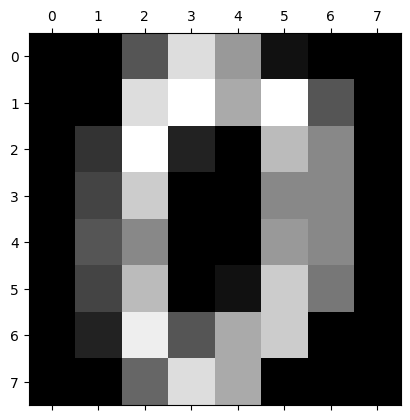

In [4]:
digits = load_digits()
print( 'shape :' , digits.data.shape)
plt.gray()
plt.matshow(digits.images[0])
plt.show()

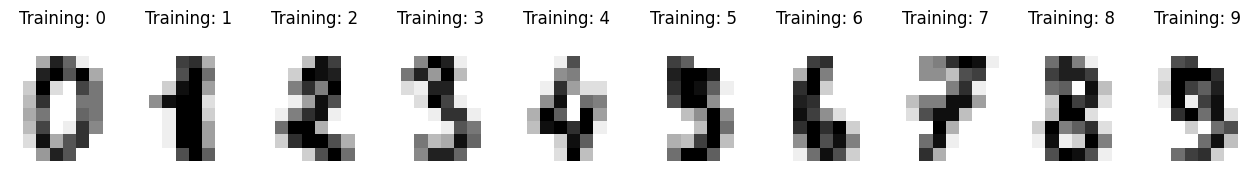

In [5]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(16, 12))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.matshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.gray()
    ax.set_title('Training: %i' % label)

In [6]:
# example : image 33

print(digits.images.shape)
digits.images[33]   #2D array   8*8

(1797, 8, 8)


array([[ 0.,  6., 13.,  5.,  8.,  8.,  1.,  0.],
       [ 0.,  8., 16., 16., 16., 16.,  6.,  0.],
       [ 0.,  6., 16.,  9.,  6.,  4.,  0.,  0.],
       [ 0.,  6., 16., 16., 15.,  5.,  0.,  0.],
       [ 0.,  0.,  4.,  5., 15., 12.,  0.,  0.],
       [ 0.,  0.,  0.,  3., 16.,  9.,  0.,  0.],
       [ 0.,  1.,  8., 13., 15.,  3.,  0.,  0.],
       [ 0.,  4., 16., 15.,  3.,  0.,  0.,  0.]])

In [7]:
# converting images to 1D arrays
# example : image 33

digits.images=np.array(digits.images).reshape(1797,64)

print(digits.images.shape)
digits.images[33]   #1D array    1*64

(1797, 64)


array([ 0.,  6., 13.,  5.,  8.,  8.,  1.,  0.,  0.,  8., 16., 16., 16.,
       16.,  6.,  0.,  0.,  6., 16.,  9.,  6.,  4.,  0.,  0.,  0.,  6.,
       16., 16., 15.,  5.,  0.,  0.,  0.,  0.,  4.,  5., 15., 12.,  0.,
        0.,  0.,  0.,  0.,  3., 16.,  9.,  0.,  0.,  0.,  1.,  8., 13.,
       15.,  3.,  0.,  0.,  0.,  4., 16., 15.,  3.,  0.,  0.,  0.])

In [8]:
# Split data into 80% train and 20% test subsets

X_train, X_test, y_train, y_test = train_test_split(digits.images, digits.target, test_size=0.2, shuffle=True, random_state=0)

print('X_train shape :  ', X_train.shape)
print('X_test shape  :  ' , X_test.shape)
print('y_train shape :  ', y_train.shape)
print('y_test shape  :  ' , y_test.shape)

X_train shape :   (1437, 64)
X_test shape  :   (360, 64)
y_train shape :   (1437,)
y_test shape  :   (360,)


In [9]:
 #Data standardization

X_scaler = StandardScaler().fit(X_train)
X_train  = X_scaler.transform(X_train)
X_test   = X_scaler.transform(X_test)


In [10]:
# now, let's take 10% of the training data and use that for validation !!!!
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train, test_size=0.1, random_state=0)

# show the sizes of each data split
print("training data points   : {}".format(len(y_train)))
print("validation data points : {}".format(len(y_validation)))
print("testing data points    : {}".format(len(y_test)))

training data points   : 1293
validation data points : 144
testing data points    : 360


# KNN :

In [11]:
# initialize the values of k for our k-Nearest Neighbor classifier along with the list of accuracies for each value of k

kVals = range(3, 10, 1)  # step:1

accuracies     = []      # empty list
k_list         = []      # empty list
knn_error_list = []      # empty list

#====================================================================================================================

# loop over various values of `k` for the k-Nearest Neighbor classifier

for k in range(3,10, 1): # train the k-Nearest Neighbor classifier with the current value of `k`
        knn_model = KNeighborsClassifier(n_neighbors=k)
        knn_model.fit(X_train, y_train)
        score = knn_model.score(X_validation, y_validation)
        print("k=%d, accuracy=%.2f%%" % (k, score * 100))
        accuracies.append(score)                            # evaluate the model and update the accuracies list
        k_list.append(k)
        knn_error_list.append(1-score)

#=====================================================================================================================

# find the value of k that has the largest accuracy
i = np.argmax(accuracies)
print('\n====================================================================')
print("k=%d achieved highest accuracy of %.2f%% on validation data" % (kVals[i], accuracies[i] * 100))
print('====================================================================')

#=====================================================================================================================

# re-train our classifier using the best k value and predict the labels of the test data
knn_model = KNeighborsClassifier(n_neighbors=kVals[i])
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

#=====================================================================================================================

# show a final classification report demonstrating the accuracy of the classifier for each of the digits

print("\nEVALUATION ON TESTING DATA")
print(classification_report(y_test, y_pred_knn))

print ("\nConfusion matrix")
print(confusion_matrix(y_test,y_pred_knn))


k=3, accuracy=95.83%
k=4, accuracy=97.22%
k=5, accuracy=96.53%
k=6, accuracy=97.92%
k=7, accuracy=97.92%
k=8, accuracy=97.22%
k=9, accuracy=97.22%

k=6 achieved highest accuracy of 97.92% on validation data

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.92      0.97      0.94        35
           2       1.00      0.94      0.97        36
           3       0.93      0.97      0.95        29
           4       0.97      0.97      0.97        30
           5       0.95      0.97      0.96        40
           6       1.00      1.00      1.00        44
           7       0.93      0.97      0.95        39
           8       0.97      0.90      0.93        39
           9       0.97      0.95      0.96        41

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360


Confu

In [12]:
knn_test_error= (y_test != y_pred_knn).mean() * 100
print('test error :', knn_test_error)

test error : 3.6111111111111107


In [13]:
knn_mse = MSE(y_test , y_pred_knn)
print('knn mse:', knn_mse)

knn mse: 0.7472222222222222


Text(0, 0.5, 'error')

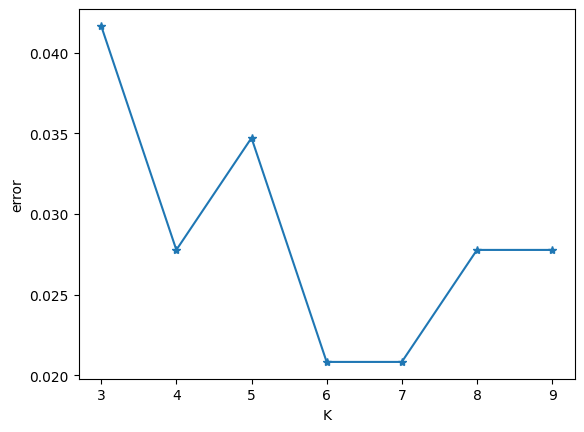

In [14]:
plt.plot(k_list,knn_error_list, marker='*')
plt.xlabel('K')
plt.ylabel('error')

# LDA :

In [15]:
n_vals = range(1,10,1)       # step:1

lda_accuracies = []          # empty list
n_list         = []          # empty list
lda_error_list = []          # empty list

for n in range(1,10,1) : # train the LDA classifier with the current value of `n`
        lda_model = LDA(n_components=n)
        X_train_lda=lda_model.fit_transform(X_train, y_train)
        X_validation_lda = lda_model.transform(X_validation)
        new_lda_model = LDA()
        new_lda_model.fit_transform(X_train_lda, y_train)
        lda_score = new_lda_model.score(X_validation_lda, y_validation)
        print("n=%d, accuracy=%.2f%%" % (n,lda_score * 100))
        lda_accuracies.append(lda_score)                        # evaluate the model and update the accuracies list
        n_list.append(n)
        lda_error_list.append(1-lda_score)



#=====================================================================================================================
# find the value of n that has the largest accuracy
i = np.argmax(lda_accuracies)
print('\n====================================================================')
print("n=%d achieved highest accuracy of %.2f%% on validation data" % (n_vals[i], lda_accuracies[i] * 100))
print('====================================================================')

#=====================================================================================================================

# re-train our classifier using the best n and predict the labels of the test data
lda_model = LDA(n_components=n_vals[i])
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_test)


# show a final classification report demonstrating the accuracy of the classifier for each of the digits
print("\nEVALUATION ON TESTING DATA")
print(classification_report(y_test, y_pred_lda))

print ("\nConfusion matrix")
print(confusion_matrix(y_test,y_pred_lda))

n=1, accuracy=40.97%
n=2, accuracy=65.97%
n=3, accuracy=84.72%
n=4, accuracy=90.97%
n=5, accuracy=93.75%
n=6, accuracy=95.83%
n=7, accuracy=95.83%
n=8, accuracy=97.22%
n=9, accuracy=95.83%

n=8 achieved highest accuracy of 97.22% on validation data

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        27
           1       0.94      0.91      0.93        35
           2       0.97      0.92      0.94        36
           3       0.93      0.97      0.95        29
           4       1.00      0.97      0.98        30
           5       0.97      0.93      0.95        40
           6       1.00      0.98      0.99        44
           7       0.93      1.00      0.96        39
           8       0.90      0.95      0.92        39
           9       0.90      0.90      0.90        41

    accuracy                           0.95       360
   macro avg       0.95      0.95      0.95       360
weighted avg       

In [16]:
lda_test_error = (y_test != y_pred_lda).mean() * 100
print('LDA test error:' , lda_test_error)

LDA test error: 5.0


In [17]:
lda_mse = MSE(y_test , y_pred_lda)
print('LDA MSE:' , lda_mse)

LDA MSE: 1.0694444444444444


Text(0, 0.5, 'error')

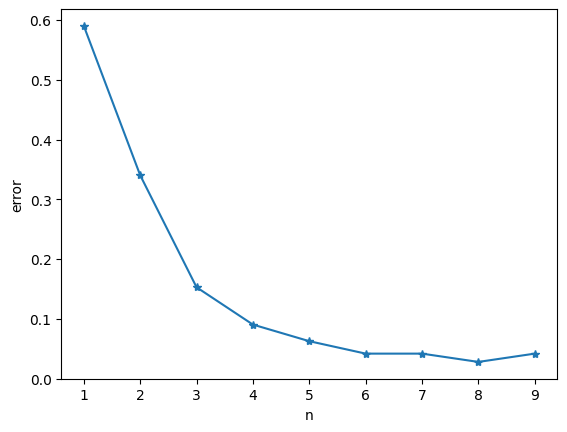

In [18]:
plt.plot(n_list,lda_error_list, marker='*')
plt.xlabel('n')
plt.ylabel('error')

# QDA :

In [19]:
qda = QDA()
qda.fit(X_train, y_train)
qda_predictions = qda.predict(X_test)

# show a final classification report demonstrating the accuracy of the classifier for each of the digits
print("EVALUATION ON TESTING DATA")
print(classification_report(y_test, qda_predictions))

print ("Confusion matrix")
print(confusion_matrix(y_test, qda_predictions))


EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        27
           1       0.80      0.91      0.85        35
           2       0.88      0.64      0.74        36
           3       1.00      0.59      0.74        29
           4       0.92      0.77      0.84        30
           5       0.95      0.95      0.95        40
           6       1.00      1.00      1.00        44
           7       0.79      0.97      0.87        39
           8       0.61      0.95      0.74        39
           9       0.97      0.83      0.89        41

    accuracy                           0.86       360
   macro avg       0.89      0.85      0.86       360
weighted avg       0.89      0.86      0.86       360

Confusion matrix
[[24  1  0  0  0  2  0  0  0  0]
 [ 0 32  1  0  0  0  0  0  2  0]
 [ 0  6 23  0  0  0  0  0  7  0]
 [ 0  0  1 17  0  0  0  0 10  1]
 [ 0  0  0  0 23  0  0  7  0  0]
 [ 0  0  0  0  0 38  0  1  1  0]

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [20]:
qda_mse = MSE(y_test , qda_predictions)
print(qda_mse)

2.5055555555555555


In [21]:
qda_test_error = (y_test != qda_predictions).mean() * 100
print(qda_test_error)

13.88888888888889


# (B) & (C)

## Dimensionality Reduction with PCA

To reduce the feature space, we use PCA. This helps speed up model training and reduces overfitting by focusing on the most important components. Let's reduce the dimensionality and visualize how many components explain the variance in the data.


In [22]:
#PCA

pca = PCA(n_components = 1)
X_train_pca=pca.fit_transform(X_train, y_train)
X_test_pca = lda_model.transform(X_test)
new_pca = PCA()
new_pca.fit_transform(X_train_pca, y_train)

#LDA
lda_model = LDA(n_components=n)
X_train_lda=lda_model.fit_transform(X_train, y_train)
X_validation_lda = lda_model.transform(X_validation)
new_lda_model = LDA()
new_lda_model.fit_transform(X_train_lda, y_train)
lda_score = new_lda_model.score(X_validation_lda, y_validation)

#QDA
qda = QDA()
qda.fit(X_train, y_train)
qda_predictions = qda.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [23]:
acc_knn_list = []
error_list   = []
for k in range (2,10, 1) :
    for n in range (1,10,1):
        random_state = 0
        # Reduce dimension to n with PCA
        pca = make_pipeline(StandardScaler(), PCA(n_components=n, random_state=random_state))
        # Reduce dimension to n with LDA
        lda = make_pipeline(StandardScaler(), LDA(n_components=n))
        # Use a nearest neighbor classifier to evaluate the methods
        knn = KNeighborsClassifier(n_neighbors=k)
        # Make a list of the methods to be compared
        dim_reduction_methods = [("PCA", pca), ("LDA", lda)]

        for i, (name, model) in enumerate(dim_reduction_methods):
            # Fit the method's model
            model.fit(X_train, y_train)
            # Fit a nearest neighbor classifier on the embedded training set
            knn.fit(model.transform(X_train), y_train)
            # Compute the nearest neighbor accuracy on the embedded test set
            acc_knn = knn.score(model.transform(X_test), y_test)
            acc_knn_list.append([name,n,k,acc_knn, (1-acc_knn)])
            error_list.append(1-acc_knn)


print(tabulate(acc_knn_list , headers=['name', 'n(components)', 'k (knn)', 'accuracy', 'total error' ], tablefmt="pretty" ))


+------+---------------+---------+---------------------+----------------------+
| name | n(components) | k (knn) |      accuracy       |     total error      |
+------+---------------+---------+---------------------+----------------------+
| PCA  |       1       |    2    | 0.2861111111111111  |  0.7138888888888889  |
| LDA  |       1       |    2    |         0.3         |         0.7          |
| PCA  |       2       |    2    | 0.48333333333333334 |  0.5166666666666666  |
| LDA  |       2       |    2    |        0.575        | 0.42500000000000004  |
| PCA  |       3       |    2    | 0.6777777777777778  |  0.3222222222222222  |
| LDA  |       3       |    2    | 0.7694444444444445  |  0.2305555555555555  |
| PCA  |       4       |    2    |        0.775        | 0.22499999999999998  |
| LDA  |       4       |    2    | 0.8527777777777777  | 0.14722222222222225  |
| PCA  |       5       |    2    | 0.8305555555555556  |  0.1694444444444444  |
| LDA  |       5       |    2    | 0.905

In [24]:
print(len(acc_knn_list))

144


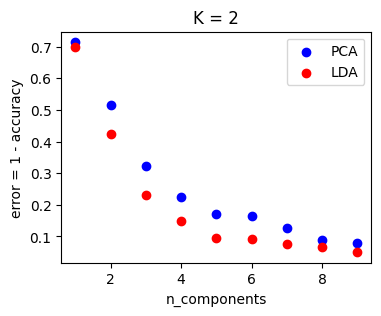

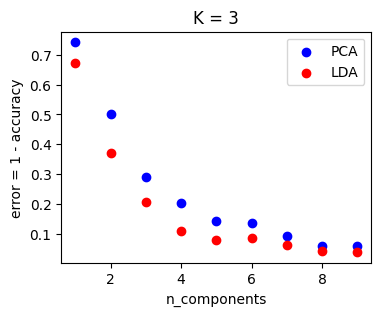

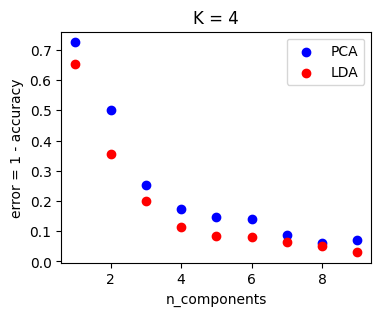

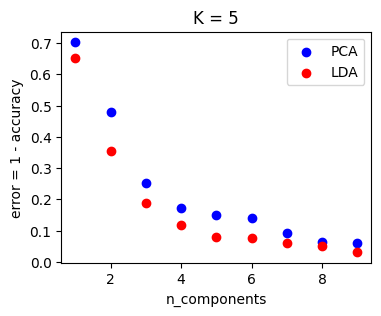

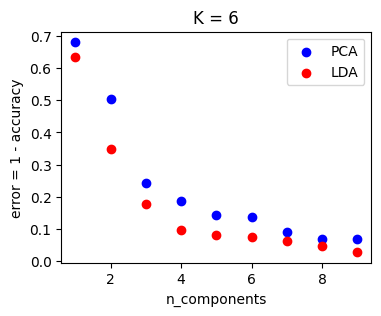

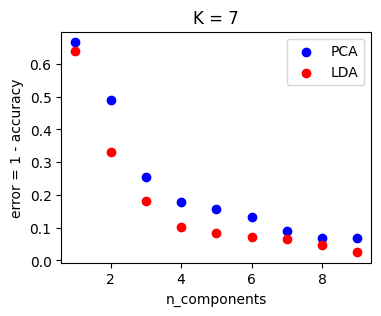

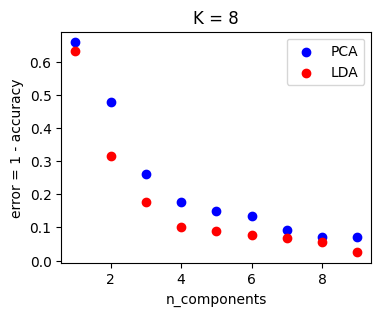

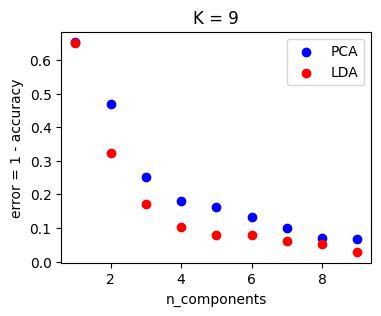

In [25]:
plt.rcParams['figure.figsize'] = (4,3)   # figure size
#----------------------------------------------------------------------------------
for i in range (144):
    if (acc_knn_list[i][2] == 2):
        if (acc_knn_list[i][0] == 'PCA'):
            plt.scatter(acc_knn_list[i][1],acc_knn_list[i][4], color = 'blue')
        if (acc_knn_list[i][0] == 'LDA'):
            plt.scatter(acc_knn_list[i][1],acc_knn_list[i][4], color = 'red')

        plt.title('K = 2')        ; plt.legend(['PCA' , 'LDA'])
        plt.xlabel('n_components'); plt.ylabel('error = 1 - accuracy')
plt.show()
#----------------------------------------------------------------------------------
for i in range (144):
    if (acc_knn_list[i][2] == 3):
        if (acc_knn_list[i][0] == 'PCA'):
            plt.scatter(acc_knn_list[i][1],acc_knn_list[i][4], color = 'blue')
        if (acc_knn_list[i][0] == 'LDA'):
            plt.scatter(acc_knn_list[i][1],acc_knn_list[i][4], color = 'red')

        plt.title('K = 3')        ; plt.legend(['PCA' , 'LDA'])
        plt.xlabel('n_components'); plt.ylabel('error = 1 - accuracy')
plt.show()
#----------------------------------------------------------------------------------
for i in range (144):
    if (acc_knn_list[i][2] == 4):
        if (acc_knn_list[i][0] == 'PCA'):
            plt.scatter(acc_knn_list[i][1],acc_knn_list[i][4], color = 'blue')
        if (acc_knn_list[i][0] == 'LDA'):
            plt.scatter(acc_knn_list[i][1],acc_knn_list[i][4], color = 'red')

        plt.title('K = 4')        ; plt.legend(['PCA' , 'LDA'])
        plt.xlabel('n_components'); plt.ylabel('error = 1 - accuracy')
plt.show()
#----------------------------------------------------------------------------------
for i in range (144):
    if (acc_knn_list[i][2] == 5):
        if (acc_knn_list[i][0] == 'PCA'):
            plt.scatter(acc_knn_list[i][1],acc_knn_list[i][4], color = 'blue')
        if (acc_knn_list[i][0] == 'LDA'):
            plt.scatter(acc_knn_list[i][1],acc_knn_list[i][4], color = 'red')

        plt.title('K = 5')        ; plt.legend(['PCA' , 'LDA'])
        plt.xlabel('n_components'); plt.ylabel('error = 1 - accuracy')
plt.show()
#----------------------------------------------------------------------------------
for i in range (144):
    if (acc_knn_list[i][2] == 6):
        if (acc_knn_list[i][0] == 'PCA'):
            plt.scatter(acc_knn_list[i][1],acc_knn_list[i][4], color = 'blue')
        if (acc_knn_list[i][0] == 'LDA'):
            plt.scatter(acc_knn_list[i][1],acc_knn_list[i][4], color = 'red')

        plt.title('K = 6')        ; plt.legend(['PCA' , 'LDA'])
        plt.xlabel('n_components'); plt.ylabel('error = 1 - accuracy')
plt.show()
#----------------------------------------------------------------------------------
for i in range (144):
    if (acc_knn_list[i][2] == 7):
        if (acc_knn_list[i][0] == 'PCA'):
            plt.scatter(acc_knn_list[i][1],acc_knn_list[i][4], color = 'blue')
        if (acc_knn_list[i][0] == 'LDA'):
            plt.scatter(acc_knn_list[i][1],acc_knn_list[i][4], color = 'red')

        plt.title('K = 7')        ; plt.legend(['PCA' , 'LDA'])
        plt.xlabel('n_components'); plt.ylabel('error = 1 - accuracy')
plt.show()
#----------------------------------------------------------------------------------
for i in range (144):
    if (acc_knn_list[i][2] == 8):
        if (acc_knn_list[i][0] == 'PCA'):
            plt.scatter(acc_knn_list[i][1],acc_knn_list[i][4], color = 'blue')
        if (acc_knn_list[i][0] == 'LDA'):
            plt.scatter(acc_knn_list[i][1],acc_knn_list[i][4], color = 'red')

        plt.title('K = 8')        ; plt.legend(['PCA' , 'LDA'])
        plt.xlabel('n_components'); plt.ylabel('error = 1 - accuracy')
plt.show()
#----------------------------------------------------------------------------------
for i in range (144):
    if (acc_knn_list[i][2] == 9):
        if (acc_knn_list[i][0] == 'PCA'):
            plt.scatter(acc_knn_list[i][1],acc_knn_list[i][4], color = 'blue')
        if (acc_knn_list[i][0] == 'LDA'):
            plt.scatter(acc_knn_list[i][1],acc_knn_list[i][4], color = 'red')

        plt.title('K = 9')        ; plt.legend(['PCA' , 'LDA'])
        plt.xlabel('n_components'); plt.ylabel('error = 1 - accuracy')
plt.show()

As observed from the various neighborhood sizes plotted in the graphs, a common trend emerges: as the number of components increases, accuracy improves, and error decreases. This was expected since reducing dimensions inevitably leads to some loss of valuable information. The more aggressive the dimensionality reduction, the more information is lost, resulting in higher error rates.

Another key observation is that, in this case, dimensionality reduction via LDA is preferred due to its lower error rates compared to other methods.

The plots also reveal that the optimal number of components is around eight or nine across all neighborhood sizes, with similar error rates in these cases.

By comparing parts (a) and (b)—specifically, the table presented above and the values obtained in part (a)—it becomes clear that the results for higher component numbers are almost within the same range as those from part (a). However, as mentioned earlier, dimensionality reduction lowers accuracy.

A final important conclusion is that although increasing the number of components improves the results and reduces overall error, the rate of improvement is not consistent across all components. For example, the improvement between eight and nine components is significantly smaller than that between one and two components.